In [2]:
!git clone https://github.com/sakanaowo/PlantXViT

Cloning into 'PlantXViT'...
remote: Enumerating objects: 50309, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 50309 (delta 7), reused 34 (delta 6), pack-reused 50271 (from 1)
Receiving objects: 100% (50309/50309), 1.66 GiB | 20.23 MiB/s, done.
Resolving deltas: 100% (30392/30392), done.
Updating files: 100% (50027/50027), done.


In [5]:
%cd PlantXViT

/kaggle/working/PlantXViT


In [6]:
!git pull


remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (1/1), done.
remote: Total 4 (delta 3), reused 4 (delta 3), pack-reused 0 (from 0)
Unpacking objects: 100% (4/4), 391 bytes | 391.00 KiB/s, done.
From https://github.com/sakanaowo/PlantXViT
   3f946f65..7b3259f5  main       -> origin/main
Updating 3f946f65..7b3259f5
Fast-forward
 src/model.py | 3 ++-
 1 file changed, 2 insertions(+), 1 deletion(-)


In [7]:
from utils.config_loader import load_config

config=load_config("configs/config.yaml")

In [13]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision.models import VGG16_Weights


# inception block
class InceptionBlock(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.branch1x1 = nn.Conv2d(in_channels, 128, kernel_size=1)

        self.branch3x3 = nn.Sequential(
            nn.Conv2d(in_channels, 128, kernel_size=(1, 3), padding=(0, 1)),
            nn.Conv2d(128, 128, kernel_size=(3, 1), padding=(1, 0)),
        )

        self.branch_pool = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels, 128, kernel_size=1),
        )

    def forward(self, x):
        b1 = self.branch1x1(x)
        b2 = self.branch3x3(x)
        b3 = self.branch_pool(x)
        return torch.cat([b1, b2, b3], dim=1)


# patch embedding: split patch -> Linear
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels, patch_size=5, emb_size=16):
        super().__init__()
        self.patch_size = patch_size
        self.emb_size = emb_size
        self.proj = nn.Linear(in_channels * patch_size * patch_size, emb_size)

    def forward(self, x):
        B, C, H, W = x.shape
        x = x.unfold(2, self.patch_size, self.patch_size).unfold(3, self.patch_size, self.patch_size)
        x = x.permute(0, 2, 3, 1, 4, 5).contiguous()
        x = x.view(B, -1, C * self.patch_size * self.patch_size)
        return self.proj(x)  # shape: (b,num patches,emb size)


# -------- Transformer Encoder Block (ViT block) --------
class TransformerBlock(nn.Module):
    def __init__(self, emb_size=16, dropout=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(emb_size)
        self.attn = nn.MultiheadAttention(emb_size, num_heads=2, batch_first=True)
        self.norm2 = nn.LayerNorm(emb_size)
        self.mlp = nn.Sequential(
            nn.Linear(emb_size, emb_size * 2),
            nn.GELU(),
            nn.Linear(emb_size * 2, emb_size),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        x_attn, _ = self.attn(self.norm1(x), self.norm1(x), self.norm1(x))
        x = x + x_attn
        x = x + self.mlp(self.norm2(x))
        return x


# -------- PlantXViT Model --------
class PlantXViT(nn.Module):
    def __init__(self, num_classes=4, patch_size=5, emb_size=16, num_blocks=4, dropout=0.1):
        super().__init__()

        # VGG16 (2 blocks)
        vgg = models.vgg16(weights=VGG16_Weights.DEFAULT)
        self.vgg_block = nn.Sequential(*list(vgg.features[:10]))
        # self.vgg_block = nn.Sequential(*vgg[:10])  # output: (B, 128, 56, 56)

        # Inception-like block → (B, 384, 56, 56)
        self.inception = InceptionBlock(in_channels=128)

        # Patch Embedding → (B, 121, 16)
        self.patch_embed = PatchEmbedding(in_channels=384, patch_size=patch_size, emb_size=emb_size)

        # Transformer blocks
        self.transformer = nn.Sequential(*[TransformerBlock(emb_size, dropout) for _ in range(num_blocks)])

        # Classification head
        self.norm = nn.LayerNorm(emb_size)
        self.global_pool = nn.AdaptiveAvgPool1d(1)  # (B, emb_size, 1)
        self.classifier = nn.Linear(emb_size, num_classes)

    def forward(self, x):
        x = self.vgg_block(x)  # (B, 128, 56, 56)
        x = self.inception(x)  # (B, 384, 56, 56)
        x = self.patch_embed(x)  # (B, 121, 16)
        x = self.transformer(x)  # (B, 121, 16)
        x = self.norm(x)  # (B, 121, 16)
        x = x.permute(0, 2, 1)  # (B, 16, 121)
        x = self.global_pool(x).squeeze(-1)  # (B, 16)
        return self.classifier(x)  # (B, num_classes)


In [10]:
print(config['output']['model_path'])

./outputs/models/plantxvit_best.pth


In [15]:
model = PlantXViT(num_classes=4)
device=torch.device("cuda")
model.to(device)
model.load_state_dict(torch.load(config['output']['model_path']))

model.eval()

PlantXViT(
  (vgg_block): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (inception): InceptionBlock(
    (branch1x1): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
    (branch3x3): Sequential(
      (0): Conv2d(128, 128, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1))
      (1): Conv2d(128, 128, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0))
    )
    (branch_pool): Sequential(
      (0): MaxPool2d(kernel_size=3, stride=1, paddin

In [19]:
import pandas as pd
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import os
import torch

In [21]:

class AppleDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform):
        self.df = dataframe
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.image_dir, row["image_id"] + '.jpg')
        image = Image.open(img_path).convert('RGB')
        image = self.transform(image)
        label = torch.tensor(row['label_idx'])
        return image, label


In [22]:
# Load CSV
val_df = pd.read_csv("data/processed/apple_val.csv")
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_dataset = AppleDataset(val_df, "./data/raw/plant-pathology-2020-fgvc7/images", val_transform)
val_loader = DataLoader(val_dataset, batch_size=16)

In [23]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    epoch_loss = running_loss / total
    accuracy = correct / total
    return epoch_loss, accuracy


In [24]:
criterion = torch.nn.CrossEntropyLoss()
val_loss, val_acc = evaluate(model, val_loader, criterion, device)

print(f"✅ Validation Loss: {val_loss:.4f} — Accuracy: {val_acc:.4f}")


✅ Validation Loss: 0.2974 — Accuracy: 0.9205


Validation Loss: 0.2974 — Accuracy: 0.9205

confusion matrix here


In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import torch

def plot_confusion_matrix(model, dataloader, device, class_names):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap='Blues', xticks_rotation=45)
    plt.title("Confusion Matrix")
    plt.show()


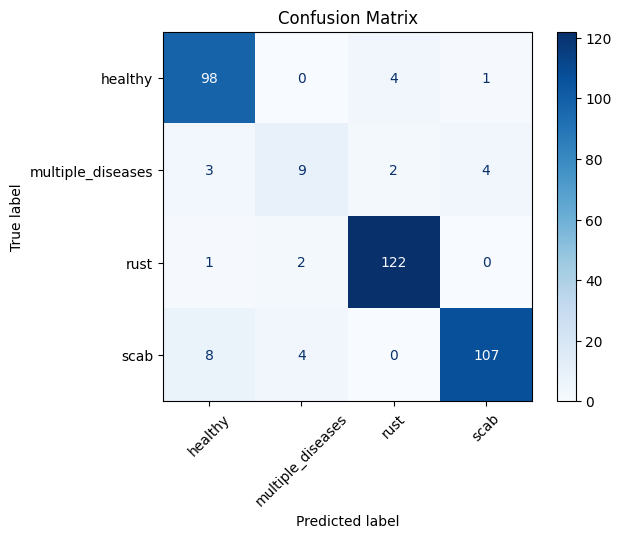

In [26]:
# Danh sách class (Apple dataset)
class_names = ['healthy', 'multiple_diseases', 'rust', 'scab']

# Giả sử val_loader và model đã sẵn sàng
plot_confusion_matrix(model, val_loader, device, class_names)
